In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.probability import FreqDist
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/priscillamorales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/priscillamorales/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/priscillamorales/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/priscillamorales/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('cleaned_file (1).csv')
df.head(10)

,subreddit,title,score,id,url,comments,creation time,content
0,narcissisticinlaws,in laws encourage bullying,1,16bjmj1,httpswwwredditcomrnarcissisticinlawscomments16...,0,20230906 125739,my inlaws have changed there parenting per chi...
1,narcissisticspouses,hidden tracker apps,2,1ddnqjb,httpswwwredditcomrnarcissisticspousescomments1...,1,20240611 200730,i think he is tracking me and im not sure if i...
2,narcissisticparents,narc mother terminal illness less than a month,3,1dg697r,httpswwwredditcomrnarcissisticparentscomments1...,1,20240615 010505,okay in short my narc mother had a brain tumor...
3,narcissisticmothers,is it fair for my mom to do this,7,1cxqpin,httpswwwredditcomrnarcissisticmotherscomments1...,4,20240522 032752,my mom doesnt like the way i dress and is now ...
4,narcissisticmothers,parents withdrawing financial support,4,1bqa2r6,httpswwwredditcomrnarcissisticmotherscomments1...,3,20240328 232635,turned 18 in january have been bombarded with...
5,narcissistparents,what do you think is in their minds,6,12vz0au,httpswwwredditcomrnarcissistparentscomments12v...,1,20230423 065218,why do narcissistic people think they need to ...
6,narcissisticfamily,girl shares her experiences of surviving narci...,1,13it9c3,httpswwwyoutubecomwatchvdnhc5stjzqa,0,20230516 030719,NaN
7,narcissisticrebound,christmas is dead,3,3rpgzd,httpswwwredditcomrnarcissisticreboundcomments3...,2,20151106 013538,last year my mother killed christmas\n\nshe us...
8,narcissisticpeople,the hero complex of a narcissist,1,1dly1ah,httpsunmaskingthenarcissistcomherocomplexofana...,0,20240622 152107,NaN
9,narcissisticparents,my abusive ex husband awarded sole physical an...,3,1dm42bi,httpswwwredditcomrnarcissisticparentscomments1...,5,20240622 195720,ii dont know how to keep this short so sorry i...


# Data Preprocessing

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subreddit      5374 non-null   object
 1   title          5369 non-null   object
 2   score          5374 non-null   int64 
 3   id             5374 non-null   object
 4   url            5374 non-null   object
 5   comments       5374 non-null   int64 
 6   creation time  5374 non-null   object
 7   content        4010 non-null   object
dtypes: int64(2), object(6)
memory usage: 336.0+ KB


In [5]:
#title and content columns must be string.
df['title'] = df['title'].astype(str)
df['content'] = df['content'].astype(str)

In [6]:
# To make clearer, date format should be changed. For example, instead of 20230906 125739, it should be 2023-09-06. 
df['creation time'] = pd.to_datetime(df['creation time'], format='%Y%m%d %H%M%S')

In [7]:
#drop Id and url columns as they are not needed for the analysis
df = df.drop(columns=['id', 'url'])

In [8]:
#add space after narcisstic, narcissism and narcissist in the subreddits column to understand the number of unique subreddits
def add_space(subreddit_name):
    keywords = ['narcissistic', 'narcissism']
    for word in keywords:
        subreddit_name = subreddit_name.replace(word, word + ' ')
    return subreddit_name

df['subreddit'] = df['subreddit'].apply(add_space)

In [10]:
#Check data is cleaned as expected
df.head()

,subreddit,title,score,comments,creation time,content
0,narcissistic inlaws,in laws encourage bullying,1,0,2023-09-06 12:57:39,my inlaws have changed there parenting per chi...
1,narcissistic spouses,hidden tracker apps,2,1,2024-06-11 20:07:30,i think he is tracking me and im not sure if i...
2,narcissistic parents,narc mother terminal illness less than a month,3,1,2024-06-15 01:05:05,okay in short my narc mother had a brain tumor...
3,narcissistic mothers,is it fair for my mom to do this,7,4,2024-05-22 03:27:52,my mom doesnt like the way i dress and is now ...
4,narcissistic mothers,parents withdrawing financial support,4,3,2024-03-28 23:26:35,turned 18 in january have been bombarded with...


# Role of Narcissist in Victims Life
## how often does mother, father, or even church leader come up in dataset? 

In [11]:
# Find unique values 
df["subreddit"].unique()

array(['narcissistic inlaws', 'narcissistic spouses',
       'narcissistic parents', 'narcissistic mothers',
       'narcissistparents', 'narcissistic family', 'narcissistic rebound',
       'narcissistic people', 'narcissistic ', 'narcissistmomsurvivor',
       'narcissistic siblings', 'narcissistic coparents', 'narcissism ',
       'narcissistapocalypse', 'narcissistrecovery', 'narcissistabuse',
       'narcissistic mil', 'narcissism survival', 'narcissistic exposed',
       'narcissistic goddess', 'narcissism recoverynow', 'narcissistmils',
       'narcissism quotes', 'narcissistic ouija', 'narcissistic abuse2',
       'narcissism rehab', 'narcissistic kids', 'narcissistwithajob'],
      dtype=object)

In [12]:
#Copy to new df for this visual analysis
df_categorization = df.copy()

In [13]:
#Convert similar subreddits to the same name
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistparents', 'narcissistic family')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic parents', 'narcissistic family')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistmomsurvivor', 'narcissistic mothers')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic mil', 'narcissistic inlaws')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistmils', 'narcissistic inlaws')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic spouses', 'narcissistic spouse or partner')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic coparents', 'narcissistic spouse or partner')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissism recoverynow', 'narcissism survival')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistrecovery', 'narcissism survival')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissism rehab', 'narcissism survival')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistabuse', 'narcissism survival')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic abuse2', 'narcissism survival')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic abuse', 'narcissism survival')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic ', 'narcissism')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissism quotes', 'narcissism')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissism ', 'narcissism')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistapocalypse', 'narcissistic people')
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic goddess', 'narcissistic people')


df_categorization["subreddit"].unique()


array(['narcissistic inlaws', 'narcissistic spouse or partner',
       'narcissistic family', 'narcissistic mothers',
       'narcissistic rebound', 'narcissistic people', 'narcissism',
       'narcissistic siblings', 'narcissism survival',
       'narcissistic exposed', 'narcissistic ouija', 'narcissistic kids',
       'narcissistwithajob'], dtype=object)

In [14]:
#individually exploring unique subreddits
Explore_narc = df.loc[df['subreddit'] == 'narcissistic ouija']    
Explore_narc.head()

,subreddit,title,score,comments,creation time,content
1261,narcissistic ouija,xoxox,5,1,2023-05-24 03:47:01,nan
2862,narcissistic ouija,rnarcissisticouija lounge,2,0,2023-05-23 20:06:26,a place for members of rnarcissisticouija to c...
3032,narcissistic ouija,this is such a good title,4,0,2023-12-27 21:37:19,nan


In [15]:
#those rows do not include any information about narcissism. Therefore, they should be removed from the dataset.
df_categorization = df_categorization[df_categorization['subreddit'] != 'narcissistic ouija']

In [16]:
#individually exploring unique subreddits
Explore_narc = df_categorization.loc[df_categorization['subreddit'] == 'narcissistwithajob']    
Explore_narc.head()

,subreddit,title,score,comments,creation time,content
3185,narcissistwithajob,about as much content on this sub as any narci...,1,0,2023-11-20 14:43:03,empty shells
3863,narcissistwithajob,narcissist with a shitty job has been created,5,1,2019-11-28 07:02:05,not much to say im a narcissist who works at a...


In [17]:
#drop row 3185 as it does not include any information about narcissism.
df_categorization = df_categorization.drop(3185)

In [18]:
#Narcissistwithajob will go to general narcissism subreddit
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistwithajob', 'narcissism')


In [19]:
#individually exploring unique subreddits
Explore_narc = df_categorization.loc[df_categorization['subreddit'] == 'narcissistic exposed']    
Explore_narc.head()


,subreddit,title,score,comments,creation time,content
222,narcissistic exposed,the quicksand heart pulling myself out of a na...,1,0,2024-04-13 05:35:03,entering a relationship with a narcissist can ...
505,narcissistic exposed,when someone is manipulating you they may,4,0,2024-05-12 21:25:18,nan
968,narcissistic exposed,understanding narcissism an introduction,1,0,2024-03-21 05:58:34,narcissism is a term that often surfaces in ev...
1071,narcissistic exposed,the echoes of our past selves,3,0,2024-04-24 19:01:43,x200b\n\nhttpspreviewreddit3n511vb6rcwc1pngwid...
1093,narcissistic exposed,the mask of philanthropy narcissism hidden beh...,1,0,2024-03-26 15:00:51,narcissism often characterized by an inflated ...


In [20]:
#narcissistic exposed will go to general narcissism subreddit
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic exposed', 'narcissism')


In [21]:
#individually exploring unique subreddits
Explore_narc = df_categorization.loc[df_categorization['subreddit'] == 'narcissistic rebound']    
Explore_narc.head()

,subreddit,title,score,comments,creation time,content
7,narcissistic rebound,christmas is dead,3,2,2015-11-06 01:35:38,last year my mother killed christmas\n\nshe us...
150,narcissistic rebound,wednesday narc woes,2,6,2015-06-17 14:43:58,what did they do to make you scream\n\nim bein...
175,narcissistic rebound,omg i dont think ive ever been so angry,2,1,2015-07-04 21:30:05,what is her fucking problem attitude all fuck...
180,narcissistic rebound,welcome this should be interesting there is no...,4,1,2015-06-14 13:37:20,nan
215,narcissistic rebound,have i made a huge mistake,3,1,2015-07-03 23:24:46,i want her to just shut up there is no kindnes...


In [22]:
#narcissistic rebound is those affected by narcissism. This will go to narcissism survival subreddit
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic rebound', 'narcissism survival')

In [23]:
#For purposes of this part of the analysis, narcissism survival subreddit will be considered as narcisisstic people subreddit
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissism survival', 'narcissistic people')


In [24]:
#noticed the title 'am i a narcissist' or variations of it in the narcissism subreddit dataset, I added as many as I could find. Those values will be set to self proclaimed narcissist subreddit.
def check_subreddit(title, content, current_subreddit):
    # Convert title to lowercase once to improve efficiency
    title_lower = title.lower()
    content_lower = content.lower()

    # List of phrases that indicate self-proclaimed narcissism
    self_narcissist = ['am i narcissistic', 'am i a narcissist', 'i think i am a narcissist', 'i have npd', 'biweekly ask a narcissist thread', 'as a narcissist', 'narcissim', 'am i a genius or narcissist', 'i am a vulnerable narcissist',
                       ' im a narcissist', 'i have npd','covert npd', 'iam narcissistic', 'im a minor and a narcissist', 'a lot of us are not bad people', 'my experience with disorder diagnoses a narcissistic perspective', 'therapy for npd',
                       'i tested high for covert narcissism', 'is there any dating app specifically for', 'narcissistic irl', 'covert narcissist', 'wheres the real narcissists at', 'being a narcissist', 'narcissist figuring himself out',
                       'grandiose npd', 'my npd', 'my narcissism', 'i just got diagnosed', 'cycle of lying', 'overcome narcissism', ' being narcissistic']
    
    # Check if any of the phrases in self_narcissist are in the title
    if any(phrase in title_lower or phrase in content_lower for phrase in self_narcissist):
        return 'self proclaimed narcissist'
    else:
        return current_subreddit

df_categorization['subreddit'] = df_categorization.apply(lambda x: check_subreddit(x['title'], x['content'], x['subreddit']), axis=1)

In [25]:
#further processing to determine frequency of naricissistic family members
def check_subreddit(title, content, current_subreddit):
    # Convert title to lowercase once to improve efficiency
    title_lower = title.lower()
    content_lower = content.lower()

    # List of phrases that indicate self-proclaimed narcissism
    family = ['nephew', 'niece', 'son', 'sister', ' brother', 'aunt', 'uncle', 'daughter', 'sil', 'parents'
              'grandmother', 'grandfather', 'grandson', 'granddaughter', 'cousin', 'family', 'nan']
    
    # Check if any of the phrases in family are in the title
    if any(phrase in title_lower or phrase in content_lower for phrase in family):
        return 'narcissistic family'
    else:
        return current_subreddit

df_categorization['subreddit'] = df_categorization.apply(lambda x: check_subreddit(x['title'], x['content'], x['subreddit']), axis=1)


In [26]:
#further processing to determine frequency of narcissitic mothers subreddit
def check_subreddit(title, content, current_subreddit):
    # Convert title to lowercase once to improve efficiency
    title_lower = title.lower()
    content_lower = content.lower()

    # List of phrases that indicate self-proclaimed narcissism
    mother = ['mom', 'mother', 'mum', 'mummy', 'mommy', 'mama', 'ma', 'mam', 'mammy', 'mothers', 'moms']
    
    # Check if any of the phrases in family are in the title
    if any(phrase in title_lower or phrase in content_lower for phrase in mother):
        return 'narcissistic mothers'
    else:
        return current_subreddit

df_categorization['subreddit'] = df_categorization.apply(lambda x: check_subreddit(x['title'], x['content'], x['subreddit']), axis=1)


In [27]:
#further processing  to determine frequency of narcissitic church leaders 
def check_subreddit(title, content, current_subreddit):
    # Convert title to lowercase once to improve efficiency
    title_lower = title.lower()
    content_lower = content.lower()

    # List of phrases that indicate self-proclaimed narcissism
    family = ['church leader', 'religious', 'holy', 'spiritual', ' holier', 'religion', 'jesus', 'christ', 'bible', 'minister', 'pastor', 'leader']
    
    # Check if any of the phrases in family are in the title
    if any(phrase in title_lower or phrase in content_lower for phrase in family):
        return 'narcissistic church leader'
    else:
        return current_subreddit

df_categorization['subreddit'] = df_categorization.apply(lambda x: check_subreddit(x['title'], x['content'], x['subreddit']), axis=1)


In [28]:
#further processing the  to determine frequency of narcissitic spouse or partner
def check_subreddit(title, content, current_subreddit):
    # Convert title to lowercase once to improve efficiency
    title_lower = title.lower()
    content_lower = content.lower()

    # List of phrases that indicate self-proclaimed narcissism
    family = ['ex', 'romantic', 'relationship', 'divorce', 'marriage', 'wife', 'husband', 'how to leave a narcissist', 'in love', 'cheats', 'cheating',
              'breakup', 'break up', 'wife', 'real ship', 'partner', 'boyfriend', 'girlfriend', 'dating', 'fiance', 'fiancee', 'lover']
    
    # Check if any of the phrases in family are in the title
    if any(phrase in title_lower or phrase in content_lower for phrase in family):
        return 'narcissistic spouse or partner'
    else:
        return current_subreddit

df_categorization['subreddit'] = df_categorization.apply(lambda x: check_subreddit(x['title'], x['content'], x['subreddit']), axis=1)


In [29]:
#further processing to determine frequency of narcissitic fathers
def check_subreddit(title, content, current_subreddit):
    # Convert title to lowercase once to improve efficiency
    title_lower = title.lower()
    content_lower = content.lower()

    # List of phrases that indicate self-proclaimed narcissism
    family = ['father', 'dad', 'fathers', 'dads', 'papa', 'pops']
    
    # Check if any of the phrases in family are in the title
    if any(phrase in title_lower or phrase in content_lower for phrase in family):
        return 'narcissistic fathers'
    else:
        return current_subreddit

df_categorization['subreddit'] = df_categorization.apply(lambda x: check_subreddit(x['title'], x['content'], x['subreddit']), axis=1)


In [31]:
#lastly, converting narcissism to narcissistic people
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissism', 'narcissistic people')

#Convert narcissistic inlaws to narcissistic family
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic inlaws', 'narcissistic family')

#convert narcissistic sibliings to narcissistic family
df_categorization['subreddit'] = df_categorization['subreddit'].replace('narcissistic siblings', 'narcissistic family')

In [32]:
save_csv = df_categorization.to_csv('categorized_file.csv', index = False)

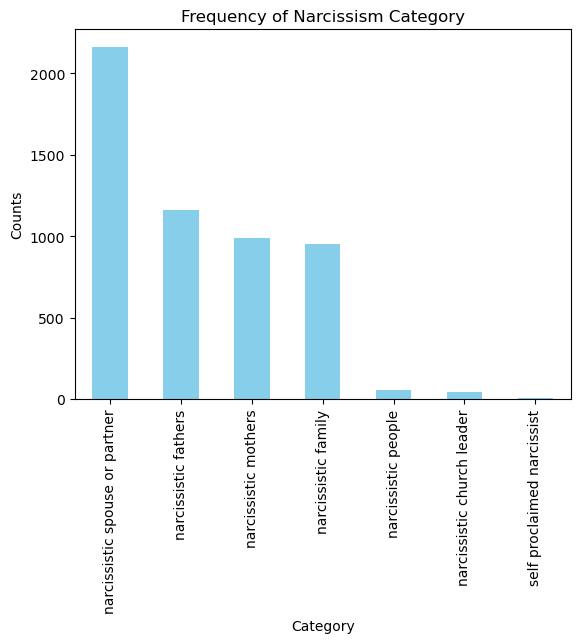

In [33]:
import matplotlib.pyplot as plt

subreddit_counts = df_categorization['subreddit'].value_counts()

# Plotting the value counts
subreddit_counts.plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title('Frequency of Narcissism Category')
plt.xlabel('Category')
plt.ylabel('Counts')

# Show the plot
plt.show()


In [34]:
#Saving the new column back to main df 
df['Narcisstics Person Category'] = df_categorization['subreddit']

# Frequency Counts of Common Victim Experiences in Content Analysis 
## The reddit posts contain which type of victim experiences and how often do they come up? 

In [35]:
#Using nltk library along with some additional stopwords and punctuations to remove and re-create these from content and title in df. 
stop_words = set(stopwords.words('english') + ['cant', 'dont', 'even', 'get', 'go', 'going', 'im', 'ive', 'like', 'really', 'want', 'told',
    'also', 'anyone', 'back', 'would', 'things', 'one', 'much', 'feeling', 'got', 'know', 'need',
    'never', 'since', 'always', 'something', 'started', 'still', 'take', 'anything', 'could',
    'getting', 'last', 'think', 'else', 'every', 'everything', 'lot', 'make', 'way', 'ago', 'year',
    'better', 'didnt', 'see', 'someone', 'went', 'well', 'thoughts', 'trying', 'first', 'need',
    'right', 'thought', 'person', 'ever', 'self', 'without', 'best', 'looking', 'day', 'feel', 'time',
    'broke', 'said', 'shes', 'hes', 'made', 'talk', 'tell', 'thing', 'days', 'away', 'around', 
    'try', 'thats', 'times', 'saying', 'wasnt', 'doesnt', 'say', 'wanted', 'nothing', 'anymore', 
    'keep', 'two', 'point', 'let', 'makes', 'asked', 'talking', 'normal', 'actually', 'come', 
    'sure', 'many', 'done', 'find', 'though', 'end', 'left', 'deal', 'maybe', 'stop', 'give', 'call',
    'whats', 'etc', 'almost', 'little', 'everyone', 'tired', 'long', 'post', 'id', 'able', 'work', 'house', 
    'another', 'says', 'lines', 'requires', 'youre', 'bye', 'ur', 'replied', 'decide', 'come', 'leave', 'take', 'use',
    'sunday', 'itll', 'runs', 'fills', 'resubmit', 'refreshes', 'comment', 'monday', '7am', 'home', 'u',
    '7pm', 'pst', 'thursday', 'x200b', 'thread', 'look', 'life', 'years', 'bc', 'live', 'old', 'older'] + ['mom', 'mother', 'family', 'love', 'dad', 'parent', 'child', 'kid', 'house', 'home', 'sister', 'brother', 'people',
                'aunt', 'uncle', 'daughter', 'son', 'cousin', 'grandmother', 'grandfather', 'grandson', 'granddaughter', 'friend',
                'niece', 'nephew', 'mum', 'mummy', 'mommy', 'mama', 'ma', 'mam', 'mammy', 'nan', 'papa', 'pops', 'sil', 'parents', 'moms', 'mothers', 'fathers', 'dads', 'sibling'])

punctuations = "!\"#$%&()*,-./:;<=>?@[\\]^_`{|}~'"
pattern = r'\b(?:' + '|'.join(stop_words) + r')\b'

df['cleaned_content'] = df['content'].str.replace(pattern, '', regex=True) #Remove stopwords
df['cleaned_content'] = df['cleaned_content'].str.replace(f"[{punctuations}]", "", regex=True) #Remove punctuations

df.head(10)


,subreddit,title,score,comments,creation time,content,Narcisstics Person Category,cleaned_content
0,narcissistic inlaws,in laws encourage bullying,1,0,2023-09-06 12:57:39,my inlaws have changed there parenting per chi...,narcissistic spouse or partner,inlaws changed parenting per fine kids...
1,narcissistic spouses,hidden tracker apps,2,1,2024-06-11 20:07:30,i think he is tracking me and im not sure if i...,narcissistic spouse or partner,tracking phone car ordered car...
2,narcissistic parents,narc mother terminal illness less than a month,3,1,2024-06-15 01:05:05,okay in short my narc mother had a brain tumor...,narcissistic spouse or partner,okay short narc brain tumor returned ...
3,narcissistic mothers,is it fair for my mom to do this,7,4,2024-05-22 03:27:52,my mom doesnt like the way i dress and is now ...,narcissistic spouse or partner,dress forbidding places dres...
4,narcissistic mothers,parents withdrawing financial support,4,3,2024-03-28 23:26:35,turned 18 in january have been bombarded with...,narcissistic fathers,turned 18 january bombarded threats kic...
5,narcissistparents,what do you think is in their minds,6,1,2023-04-23 06:52:18,why do narcissistic people think they need to ...,narcissistic spouse or partner,narcissistic put asking questions \...
6,narcissistic family,girl shares her experiences of surviving narci...,1,0,2023-05-16 03:07:19,nan,narcissistic spouse or partner,
7,narcissistic rebound,christmas is dead,3,2,2015-11-06 01:35:38,last year my mother killed christmas\n\nshe us...,narcissistic spouse or partner,killed christmas\n\n uses gifts substitut...
8,narcissistic people,the hero complex of a narcissist,1,0,2024-06-22 15:21:07,nan,narcissistic spouse or partner,
9,narcissistic parents,my abusive ex husband awarded sole physical an...,3,5,2024-06-22 19:57:20,ii dont know how to keep this short so sorry i...,narcissistic fathers,ii short sorry advance desperate...


In [36]:
#Define target terms
target_terms = {
    'Emotional Abuse': ['gaslight', 'gaslighted', 'gaslighting', 'manipulate', 'manipulated', 'manipulation', 'emotional blackmail', 
                        'guilts me', 'manipulates', 'messing with my mind', 'making me question myself', 'me feel crazy', 'boundaries', 'boundary',
                        'crazy', 'manipulates my feelings', 'uses my emotions against me', 'vulnerability against me', 'emotional abuse', 'emotionally abusive'],
    'Isolation': ['isolated', 'isolating', 'isolation', 'cut off from friends', 'me from seeing family', 'me feel alone', 'alone', 'me jealous''smear campaign', 
                  'smearing', 'defame', 'defaming', 'lies about me', 'tells everyone', 'ruining my reputation', 'badmouthing', 'triangulate', 'triangulated', 
                  'triangulation', 'pits me against others', 'uses others against me'],
    'Criticism': ['criticize', 'criticizes', 'criticized', 'critical', 'criticism', 'make fun of', 'mock', 'mocked', 'mocking', 'good enough', 
                  'puts me down', 'always finding faults', 'verbal abuse', 'verbally abusive', 'bullying', 'bully', 'bullied', 'belittles', 'belittled'],
    'Coercive Control': ['hoover', 'hoovered', 'hoovering', 'trackers', 'tracking', 'detective', 'suck me back in', 'let me go', 'control me', 'control my life',  
                        'keeps coming back', 'blackmailing', 'blackmail', 'control', 'dominate', 'dictate', 'dress', 'dressed', 'clothes'],
    'Physical Abuse': ['physical abuse', 'physically abusive', 'violent', 'hit', 'bruised', 'domestic violence', 'domestic abuse', 'hurt me'],
    'Financial Control': ['financial abuse', 'financially abusive', 'control finances', 'financial control', 'withdrawing financial', 'child support', 'paying child support',
                        'money', 'controls my money', 'me have money', 'keeps tabs on my spending', 'financial leash', 'finances', 'paying support'],
}


In [37]:
from collections import Counter

# Create a counter to store the frequency of each term
frequency_counter = Counter()

# Function to update the counter based on the target terms
def update_frequency(tokens, target_terms):
    for term, variations in target_terms.items():
        for variation in variations:
            frequency_counter[term] += tokens.count(variation)

df['cleaned_content'].apply(lambda x: update_frequency(word_tokenize(x.lower()), target_terms))

# Print the results
print(frequency_counter)

Counter({'Emotional Abuse': 1333, 'Financial Control': 1027, 'Coercive Control': 705, 'Isolation': 667, 'Criticism': 329, 'Physical Abuse': 282})


In [38]:
# Save counter into a variable to save to df
frequency_counter_gen_targets= Counter({'Emotional Abuse': 1333, 'Financial Control': 1027, 'Coercive Control': 705, 'Isolation': 667, 'Criticism': 329, 'Physical Abuse': 282})

In [39]:
#Creating DF with the frequency of each target term to visualize in Tableau
df_targets = pd.DataFrame(frequency_counter_gen_targets.items(), columns=['Term', 'Frequency'])
save_csv = df_targets.to_csv('victim_experience_category_2.csv', index = False)   

In [40]:
# Find frequency of each word or phrase used in the target terms

# Reset the counter
frequency_counter = Counter()

# Ensure consistent tokenization and counting
def update_frequency(text, target_terms):
    tokens = word_tokenize(text.lower())  # Consistent tokenization
    found_terms = []
    for category, variations in target_terms.items():
        for variation in variations:
            term_count = tokens.count(variation)
            frequency_counter[variation] += term_count  # Update global counter
            if term_count > 0:
                found_terms.append(variation)
    return ', '.join(set(found_terms))  # Remove duplicates and convert to string

# Apply the function
df['Found Terms'] = df['cleaned_content'].apply(lambda x: update_frequency(x, target_terms))

# Inspect results
print(df['Found Terms'])
print(frequency_counter)


0                 bullied
1                tracking
2                        
3          dress, clothes
4       money, boundaries
              ...        
5369                     
5370                     
5371                     
5372                     
5373                money
Name: Found Terms, Length: 5374, dtype: object
Counter({'money': 979, 'alone': 559, 'control': 384, 'crazy': 356, 'boundaries': 328, 'hit': 228, 'clothes': 171, 'gaslighting': 162, 'manipulation': 157, 'manipulate': 102, 'manipulated': 74, 'boundary': 71, 'gaslight': 58, 'criticism': 57, 'dress': 54, 'isolated': 51, 'violent': 49, 'finances': 48, 'bullied': 43, 'critical': 42, 'bully': 42, 'bullying': 37, 'dressed': 22, 'isolation': 21, 'belittled': 21, 'gaslighted': 15, 'criticize': 15, 'criticizes': 15, 'criticized': 15, 'hoovering': 15, 'mocking': 13, 'tracking': 13, 'belittles': 12, 'triangulation': 11, 'hoover': 11, 'blackmail': 11, 'manipulates': 10, 'isolating': 10, 'mock': 10, 'mocked': 7, 'domina

In [41]:
#Save counter to variable to save to df
frequency_counter_found_terms = Counter({'money': 979, 'alone': 559, 'control': 384, 'crazy': 356, 'boundaries': 328, 'hit': 228, 'clothes': 171, 'gaslighting': 162, 'manipulation': 157, 'manipulate': 102, 'manipulated': 74, 'boundary': 71, 'gaslight': 58, 'criticism': 57, 'dress': 54, 'isolated': 51, 'violent': 49, 'finances': 48, 'bullied': 43, 'critical': 42, 'bully': 42, 'bullying': 37, 'dressed': 22, 'isolation': 21, 'belittled': 21, 'gaslighted': 15, 'criticize': 15, 'criticizes': 15, 'criticized': 15, 'hoovering': 15, 'mocking': 13, 'tracking': 13, 'belittles': 12, 'triangulation': 11, 'hoover': 11, 'blackmail': 11, 'manipulates': 10, 'isolating': 10, 'mock': 10, 'mocked': 7, 'dominate': 7, 'smearing': 5, 'blackmailing': 5, 'dictate': 5, 'bruised': 5, 'badmouthing': 4, 'hoovered': 4, 'triangulate': 3, 'detective': 3, 'triangulated': 2, 'defaming': 1, 'emotional blackmail': 0, 'guilts me': 0, 'messing with my mind': 0, 'making me question myself': 0, 'me feel crazy': 0, 'manipulates my feelings': 0, 'uses my emotions against me': 0, 'vulnerability against me': 0, 'emotional abuse': 0, 'emotionally abusive': 0, 'cut off from friends': 0, 'me from seeing family': 0, 'me feel alone': 0, 'me jealoussmear campaign': 0, 'defame': 0, 'lies about me': 0, 'tells everyone': 0, 'ruining my reputation': 0, 'pits me against others': 0, 'uses others against me': 0, 'make fun of': 0, 'good enough': 0, 'puts me down': 0, 'always finding faults': 0, 'verbal abuse': 0, 'verbally abusive': 0, 'trackers': 0, 'suck me back in': 0, 'let me go': 0, 'control me': 0, 'control my life': 0, 'keeps coming back': 0, 'physical abuse': 0, 'physically abusive': 0, 'domestic violence': 0, 'domestic abuse': 0, 'hurt me': 0, 'financial abuse': 0, 'financially abusive': 0, 'control finances': 0, 'financial control': 0, 'withdrawing financial': 0, 'child support': 0, 'paying child support': 0, 'controls my money': 0, 'me have money': 0, 'keeps tabs on my spending': 0, 'financial leash': 0, 'paying support': 0})

In [42]:
# Convert the Counter object to a DataFrame
df_found_terms = pd.DataFrame(frequency_counter_found_terms.items(), columns=['Term', 'Frequency'])
save_csv = df_found_terms.to_csv('found_terms_frequency.csv', index = False)   

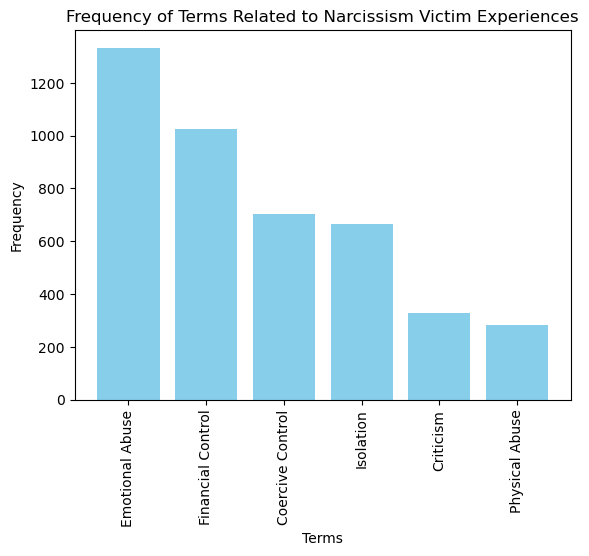

In [43]:

# Plotting the frequencies
plt.bar(frequency_counter_gen_targets.keys(), frequency_counter_gen_targets.values(), color='skyblue')
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Frequency of Terms Related to Narcissism Victim Experiences')
plt.xticks(rotation=90)
plt.show()

In [44]:
save_csv = df.to_csv('final_file.csv', index = False)

# NMF clustering of titles
## What are the most common topics found in the reddit posts content? 

In [45]:
#Using nltk library along with some additional stopwords and punctuations to remove and re-create these from content and title in df. 
stop_words = set(stopwords.words('english') + [
    'cant', 'dont', 'even', 'get', 'go', 'going', 'im', 'ive', 'like', 'really', 'want',
    'also', 'anyone', 'back', 'would', 'things', 'one', 'much', 'feeling', 'got', 'know',
    'never', 'since', 'always', 'something', 'started', 'still', 'take', 'anything', 'could',
    'getting', 'last', 'think', 'else', 'every', 'everything', 'lot', 'make', 'way', 'ago',
    'better', 'didnt', 'see', 'someone', 'went', 'well', 'thoughts', 'trying', 'first', 'want',
    'right', 'thought', 'person', 'ever', 'self', 'without', 'best', 'looking', 'day', 'el',
    'broke', 'said', 'shes', 'hes', 'made', 'talk', 'tell', 'thing', 'days', 'away', 'around', 
    'try', 'thats', 'times', 'saying', 'wasnt', 'doesnt', 'say', 'wanted', 'nothing', 'anymore', 
    'keep', 'two', 'point', 'let', 'makes', 'asked', 'talking', 'normal', 'actually', 'come', 
    'sure', 'many', 'done', 'find', 'though', 'end', 'left', 'deal', 'maybe', 'stop', 'give', 
    'whats', 'etc', 'almost', 'little', 'everyone', 'tired', 'long', 'post', 'id', 'able', 'visitorscodependents',
    'another', 'says', 'lines', 'requires', 'youre', 'bye', 'ur', 'replied', 'decide', 'narcissistborderlinerhistrionicsociopath',
    'sunday', 'itll', 'runs', 'fills', 'resubmit', 'refreshes', 'comment', 'monday', '7am', 
    '7pm', 'pst', 'thursday', 'x200b', 'thread', 'look', 'life', 'year', 'bc', 'live', 'old', 'older'
] + ['mom', 'mother', 'family', 'love', 'dad', 'parent', 'child', 'kid', 'house', 'home', 'sister', 'brother', 'people',
                'aunt', 'uncle', 'daughter', 'son', 'cousin', 'grandmother', 'grandfather', 'grandson', 'granddaughter', 'friend',
                'niece', 'nephew', 'mum', 'mummy', 'mommy', 'mama', 'ma', 'mam', 'mammy', 'nan', 'papa', 'pops', 'sil', 'parents', 'mom', 'moms', 'mothers', 'fathers', 'dads', 'sibling'])

punctuations = "!\"#$%&()*,-./:;<=>?@[\\]^_`{|}~'"
pattern = r'\b(?:' + '|'.join(stop_words) + r')\b'

df['cleaned_title'] = df['title'].str.replace(pattern, '', regex=True) #Remove stopwords
df['cleaned_title'] = df['cleaned_title'].str.replace(f"[{punctuations}]", "", regex=True) #Remove punctuations

df.head(3)

,subreddit,title,score,comments,creation time,content,Narcisstics Person Category,cleaned_content,Found Terms,cleaned_title
0,narcissistic inlaws,in laws encourage bullying,1,0,2023-09-06 12:57:39,my inlaws have changed there parenting per chi...,narcissistic spouse or partner,inlaws changed parenting per fine kids...,bullied,laws encourage bullying
1,narcissistic spouses,hidden tracker apps,2,1,2024-06-11 20:07:30,i think he is tracking me and im not sure if i...,narcissistic spouse or partner,tracking phone car ordered car...,tracking,hidden tracker apps
2,narcissistic parents,narc mother terminal illness less than a month,3,1,2024-06-15 01:05:05,okay in short my narc mother had a brain tumor...,narcissistic spouse or partner,okay short narc brain tumor returned ...,,narc terminal illness less month


In [46]:
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

#To lemmatize effectively, it's beneficial to provide the part of speech (POS) tags to the lemmatizer so that it can process the words more accurately:\
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts."""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
    return lemmatized_output

In [47]:
#Pass the cleaned title to the lemmatize_text function to lemmatize the title
df['lemmatized_title'] = df['cleaned_title'].apply(lemmatize_text)

In [48]:
# Create an instance of the TfidfVectorizer and set the max_df to 0.95 and min_df to 10, and use the English stopwords to be ignored.
tfidf = TfidfVectorizer(max_df=0.95, min_df=10, stop_words='english')
tfidf

TfidfVectorizer(max_df=0.95, min_df=10, stop_words='english')

In [49]:
# Transform each row from the cleaned content Series to a DTM.
dtm = tfidf.fit_transform(df["lemmatized_title"])
# Get the shape of the DTM.
print(dtm.shape)

(5374, 337)


In [50]:
# Get the feature names (words) from the TfidfVectorizer
feature_names = tfidf.get_feature_names_out()

# Get all the non-zero elements from the first row.
non_zero_elements = dtm.toarray()[0]

# Get the indices for each non-zero element.
non_zero_indices = non_zero_elements.nonzero()[0]

# Print out the word and the number of times the word is in the row. 
for idx in non_zero_indices:
    print(f"Word: {feature_names[idx]} | Word index {idx} | Value = {non_zero_elements[idx]}")

Word: law | Word index 155 | Value = 1.0


In [51]:
# Decided to move forward with 4 clusters to get the most distinct topics, using more clusters let to more overlapping topics.
nmf_model = NMF(n_components=4,random_state=42)
# Fit the model with our DTM data. 
nmf_model.fit(dtm)

NMF(n_components=4, random_state=42)

In [52]:
# Get the length of the array of each topic. It should be the same as the vocabulary.
for index,topic in enumerate(nmf_model.components_):
    print(len(nmf_model.components_[index]))

337
337
337
337


In [53]:
# Print the top 20 words for each topic
for index,topic in enumerate(nmf_model.components_):
    print(f'The top 30 words for topic #{index+1}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-30:]])
    print('\n')

The top 30 words for topic #1
['dr', 'husband', 'complex', 'turn', 'reason', 'gaslighting', 'feel', 'tactic', 'contact', 'date', 'deal', '10', 'ex', 'sign', 'toxic', 'abuse', '2023', 'short', 'control', 'divorce', 'way', 'relationship', 'covert', 'narcabuse', 'leave', 'boundary', 'ask', 'biweekly', 'use', 'narcissist']


The top 30 words for topic #2
['story', 'share', 'journey', 'law', 'disorder', 'deal', 'book', 'year', 'child', 'personality', 'narcissism', '10', 'cycle', 'husband', 'podcast', 'behavior', 'heal', 'feel', 'trait', 'contact', 'emotional', 'toxic', 'father', 'survive', 'ex', 'recovery', 'sign', 'relationship', 'abuse', 'narcissistic']


The top 30 words for topic #3
['month', 'start', 'handle', 'mad', 'feel', 'contact', 'boundary', 'help', 'nc', 'bad', 'ask', 'use', 'deal', 'divorce', 'partner', 'therapy', 'want', 'turn', 'happy', 'covert', 'time', 'el', 'today', 'ex', 'leave', 'father', 'spouse', 'husband', 'abuse', 'narc']


The top 30 words for topic #4
['nm', 'time'

Best Guess at Title Topics
- Topic 1: Manipulative Dynamics in Intimate Relationships
- Topic 2: Personal Recovery and Legal Discourse
- Topic 3: Coping Strategies and Support
- Topic 4: Family Dynamics and Narcissistic Influence


In [54]:
topic_results = nmf_model.transform(dtm)
topic_results.shape

(5374, 4)

In [55]:
# Get the sorted indices for each topic in the first title.
sorted_indices = np.argsort(-topic_results[0])
# Print the ranking of topics for the title
print("Ranking of topics for the first title:")
for rank, topic_index in enumerate(sorted_indices):
    print(f"   Rank {rank+1}: Topic {topic_index+1}, Probability: {topic_results[0, topic_index]:.6f}")

Ranking of topics for the first title:
   Rank 1: Topic 2, Probability: 0.003101
   Rank 2: Topic 4, Probability: 0.002098
   Rank 3: Topic 3, Probability: 0.001456
   Rank 4: Topic 1, Probability: 0.000040


In [56]:
topic_labels = {
    1: 'Manipulative Dynamics in Intimate Relationships',
    2: 'Personal Recovery and Legal Discourse',
    3: 'Coping Strategies and Support',
    4: 'Family Dynamics and Narcissistic Influence'
}

In [57]:
# Define a function and pass in the DataFrame, the topic_results, and topic_labels dictionary.
def add_topic_labels(df, topic_results, topic_labels):
    # Find the dominant topic for each document and add the label to a new column
    df['topic'] = topic_results.argmax(axis=1) + 1
    # Use the map function to add the topic label to the news summary based on the topic number.
    df['topic_label'] = df['topic'].map(topic_labels)

In [61]:
#create new df with only the title column
df_NMF_results = df.loc[:, ['title']]


In [62]:
# Call the function to add topic labels to your DataFrame.
add_topic_labels(df_NMF_results, topic_results, topic_labels)

In [65]:
df_NMF_results.head(10)  

,title,topic,topic_label
0,in laws encourage bullying,2,Personal Recovery and Legal Discourse
1,hidden tracker apps,2,Personal Recovery and Legal Discourse
2,narc mother terminal illness less than a month,3,Coping Strategies and Support
3,is it fair for my mom to do this,1,Manipulative Dynamics in Intimate Relationships
4,parents withdrawing financial support,4,Family Dynamics and Narcissistic Influence
5,what do you think is in their minds,4,Family Dynamics and Narcissistic Influence
6,girl shares her experiences of surviving narci...,2,Personal Recovery and Legal Discourse
7,christmas is dead,2,Personal Recovery and Legal Discourse
8,the hero complex of a narcissist,1,Manipulative Dynamics in Intimate Relationships
9,my abusive ex husband awarded sole physical an...,3,Coping Strategies and Support
